In [1]:
import json
import sys

import albumentations as A
import segmentation_models_pytorch as smp
import torch
from torch.utils.data import DataLoader

import medtool.data.feta_dataset as feta_dataset

with open('../configs/tissue_annotation.json', 'r') as f:
    config = json.load(f)

In [2]:
data, labels = feta_dataset.get_path('../' + config['data_path'])

train_data, valid_data     = data[:65], data[65:]
train_labels, valid_labels = labels[:65], labels[65:]

train_dataset = feta_dataset.FeTA(
    sorted(train_data * 256), 
    sorted(train_labels * 256)
)
valid_dataset = feta_dataset.FeTA(
    sorted(valid_data * 256), 
    sorted(valid_labels * 256)
)

train_loader = DataLoader(
    train_dataset, 
    batch_size=config['batch_size'], 
    shuffle=True, 
    num_workers=config['num_workers'], 
    drop_last=True
)
valid_loader = DataLoader(
    valid_dataset, 
    batch_size=config['batch_size'], 
    shuffle=False, 
    num_workers=config['num_workers'], 
    drop_last=False
)

In [3]:
import matplotlib.pyplot as plt

In [4]:
tmp = train_dataset[257]

In [5]:
tmp['masks'].shape

torch.Size([7, 256, 256])

In [6]:
tmp['image'].shape

torch.Size([1, 256, 256])

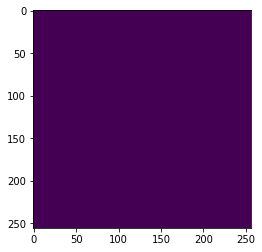

In [56]:
plt.imshow(tmp['masks'][0])

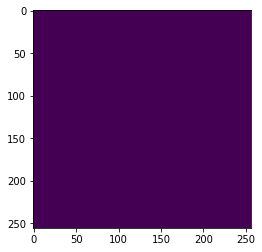

In [57]:
plt.imshow(tmp['image'])

In [ ]:


model = smp.UnetPlusPlus(
    encoder_name    = config["model"], 
    encoder_weights = config["pretrained"],
    in_channels     = config["in_channels"],
    classes         = config["classes"],
    activation      = config["activation"]
)

loss = smp.utils.base.SumOfLosses(
    smp.utils.losses.DiceLoss(),
    smp.utils.losses.BCELoss()
)

metrics = [
    smp.utils.metrics.IoU(threshold=0.5)
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=config['device'],
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=config['device'],
    verbose=True,
)

max_score = 0
patience = 0

for i in range(0, 150):
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    wandb.log({
        "train_loss" : train_logs['dice_loss + bce_loss'],
        "val_loss"   : valid_logs['dice_loss + bce_loss'],
        "IoU"        : valid_logs['iou_score']
    })

    optimizer.param_groups[0]['lr'] *= 0.97
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, f"models/saved/{config['model_name']}.pth")
        print('Model saved!')
        patience = 0
    else:
        patience += 1
    
    if patience == config['patience']:
        break